<a href="https://colab.research.google.com/github/swiryat/Alice-skill/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22pipeline%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка и настройка библиотек

In [1]:
pip install category_encoders -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, accuracy_score, classification_report
from category_encoders import TargetEncoder

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Загрузка данных

In [3]:
!gdown 1eQ4J2Geqs0VUK0Cwuv9soE54U3iYCl1a

Downloading...
From: https://drive.google.com/uc?id=1eQ4J2Geqs0VUK0Cwuv9soE54U3iYCl1a
To: /content/Bank_Customer_Churn_Prediction.csv
100% 562k/562k [00:00<00:00, 38.5MB/s]


In [4]:
try:
  df = pd.read_csv('Bank_Customer_Churn_Prediction.csv', index_col='customer_id')
except:
  df = pd.read_csv('/content/Bank_Customer_Churn_Prediction.csv', index_col='customer_id')
X = df.drop(columns='churn')
y = df.churn
X.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
customer_id,,,,,,,,,,
15634602,619,France,Female,42,2,0.00,1,1,1,101348.88
15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57
15701354,699,France,Female,39,1,0.00,2,0,0,93826.63
15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [5]:
X['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [6]:
X['country'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [7]:
y.value_counts(normalize=True)

,proportion
churn,
0,0.7963
1,0.2037


In [8]:
features_int = X.select_dtypes(include='number').columns.to_list()
features_int

['credit_score',
 'age',
 'tenure',
 'balance',
 'products_number',
 'credit_card',
 'active_member',
 'estimated_salary']

In [9]:
features_cat = X.select_dtypes(exclude='number').columns.to_list()
features_cat

['country', 'gender']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape

((8000, 10), (2000, 10))

In [11]:
np.mean(y)

np.float64(0.2037)

In [12]:
np.mean(y_train), np.mean(y_test)

(np.float64(0.20375), np.float64(0.2035))

# Pipeline

## without pipeline

In [13]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', sparse_output=False)

model = LogisticRegression(random_state=42)

X_train_scaled = scaler.fit_transform(X_train[features_int])
X_test_scaled = scaler.transform(X_test[features_int])


X_train_ohe = encoder.fit_transform(X_train[features_cat])
X_test_ohe = encoder.transform(X_test[features_cat])

In [14]:
# Объединяем в один массив
X_train_processed = np.hstack([X_train_scaled, X_train_ohe])
X_test_processed = np.hstack([X_test_scaled, X_test_ohe])


In [15]:
# Преобразуем обратно в DataFrame с названиями столбцов
num_columns = features_int  # числовые столбцы остаются с теми же именами
cat_columns = encoder.get_feature_names_out(features_cat)  # новые имена после OHE

all_columns = np.concatenate([num_columns, cat_columns])
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_columns, index=X_test.index)

X_test_processed_df.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_Germany,country_Spain,gender_Male
customer_id,,,,,,,,,,,
15749540,-0.680735,-0.279932,0.684723,-1.226059,0.808830,0.641042,-1.030206,-0.095021,0.0,0.0,1.0
15807340,-1.301915,-0.564935,-0.350971,0.877113,0.808830,-1.559960,-1.030206,-0.778941,1.0,0.0,1.0
15801062,-0.970619,0.100072,-0.350971,-1.226059,0.808830,-1.559960,0.970680,0.099469,0.0,1.0,0.0
15572801,-0.121674,-0.469934,-0.005739,1.011458,0.808830,-1.559960,-1.030206,-1.147374,0.0,1.0,1.0
15600708,-0.111321,-0.469934,-0.696202,0.023204,-0.910256,0.641042,0.970680,1.200283,0.0,1.0,0.0


In [16]:
model.fit(X_train_processed, y_train)

LogisticRegression(random_state=42)

In [17]:
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.77475626628169


## with pipeline

### explanation

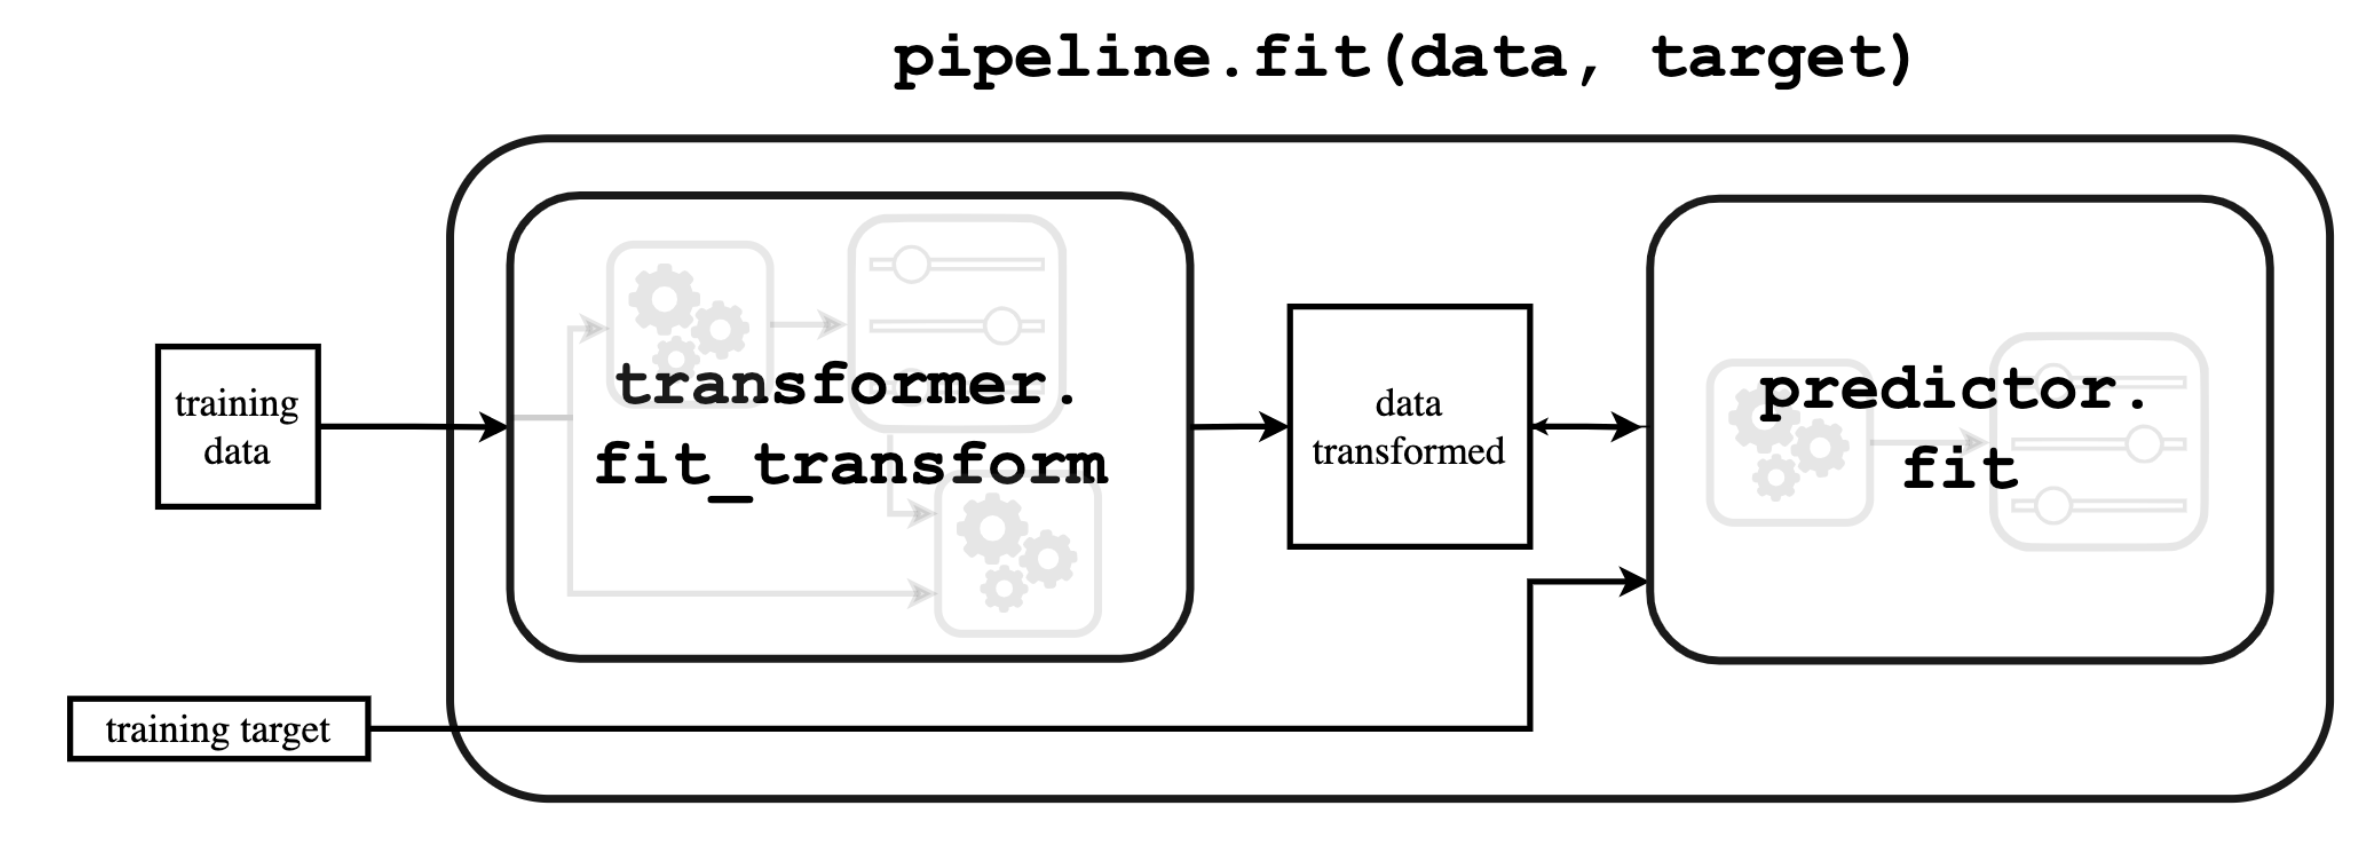

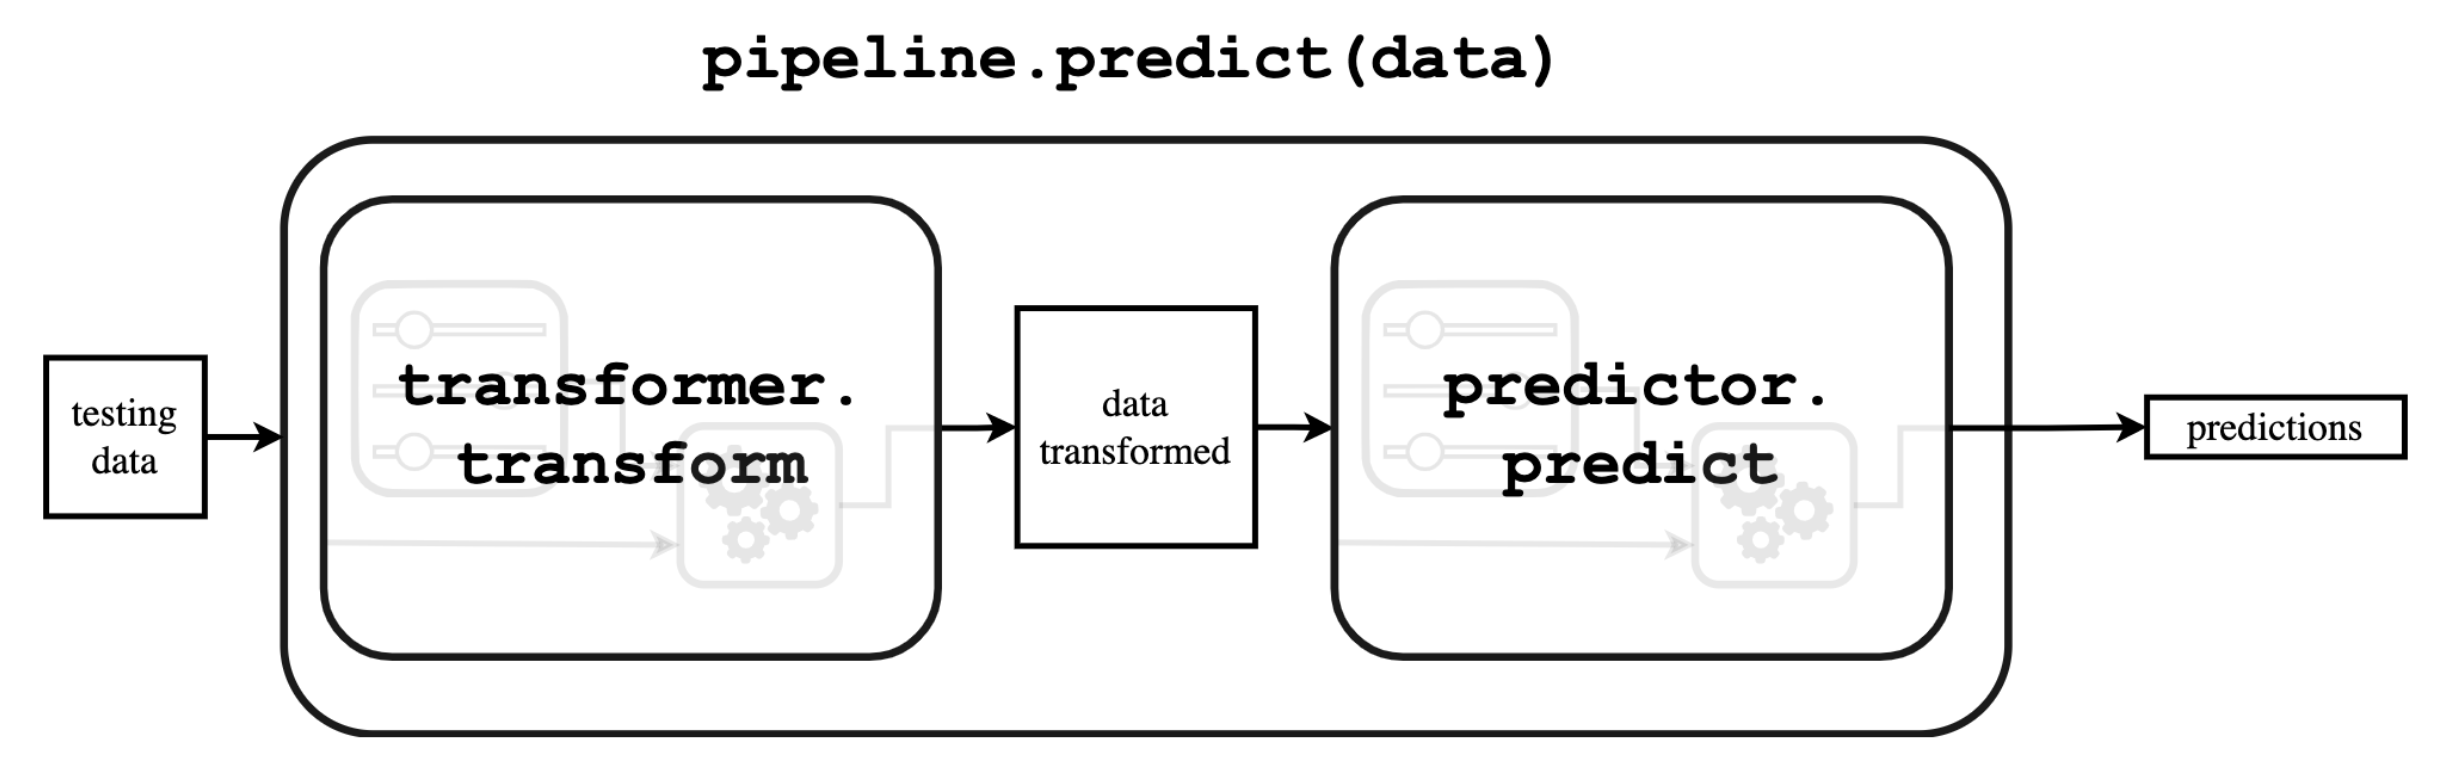

### example pipeline

In [18]:
from sklearn.pipeline import Pipeline, make_pipeline

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('model', LogisticRegression(random_state=42))])
pipeline


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(random_state=42))])

In [19]:
pipeline.steps

[('scaler', StandardScaler()), ('model', LogisticRegression(random_state=42))]

In [20]:
pipeline_make = make_pipeline(StandardScaler(),
                              LogisticRegression())
pipeline_make

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [21]:
pipeline_make.steps

[('standardscaler', StandardScaler()),
 ('logisticregression', LogisticRegression())]

In [22]:
pipeline_make.fit(X_train[features_int], y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [23]:
pred = pipeline_make.predict_proba(X_test[features_int])

In [24]:
pred

array([[0.83895175, 0.16104825],
       [0.75147639, 0.24852361],
       [0.90920327, 0.09079673],
       ...,
       [0.50959921, 0.49040079],
       [0.82342744, 0.17657256],
       [0.76460466, 0.23539534]])

### column_transformer

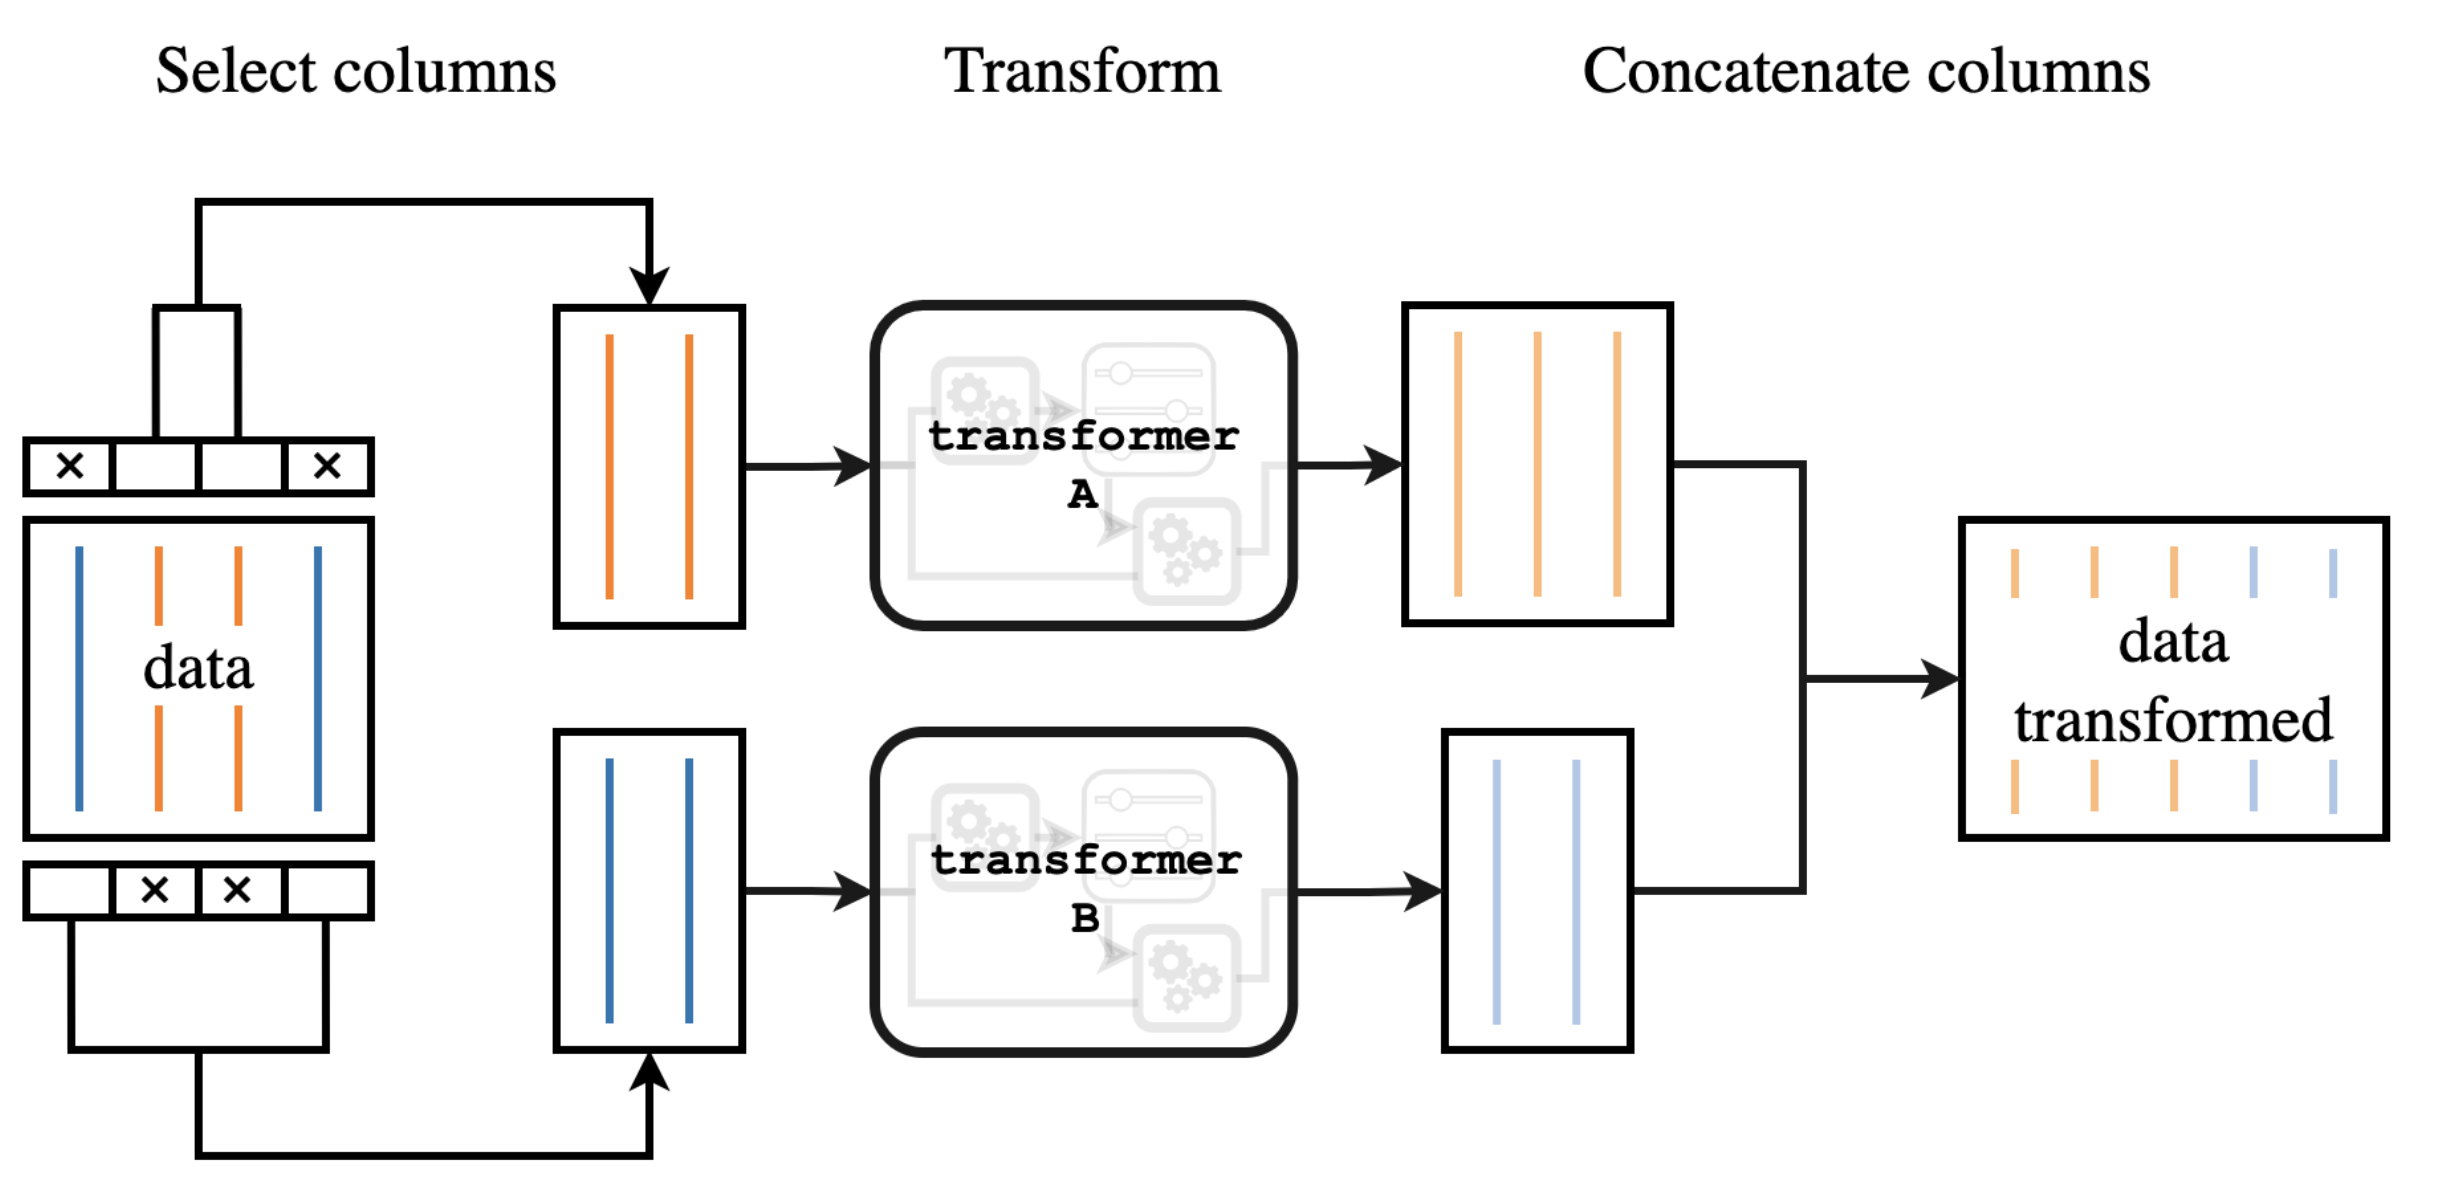

### example

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
from sklearn.impute import SimpleImputer

In [27]:
column_transformer = make_column_transformer((StandardScaler(), make_column_selector(dtype_include='number')),
                                             (SimpleImputer(missing_values=np.nan, strategy='mean'), make_column_selector(dtype_include='number')),
                                             (OneHotEncoder(drop='first'), make_column_selector(dtype_exclude='number')),
                                              remainder='passthrough')

model = LogisticRegression(random_state=42, max_iter=10000, solver='saga')

pipeline = make_pipeline(column_transformer, model)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f33c03ce1d0>),
                                                 ('simpleimputer',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f340c1a58d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f33c4df9f10>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, random_state=42,
                                    solver='saga'))])

In [28]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f33c03ce1d0>),
                                                 ('simpleimputer',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f340c1a58d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f33c4df9f10>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, random_state=42,
                                    solver='saga'))])

In [29]:
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")


Accuracy: 0.8035


In [30]:
pipeline.steps

[('columntransformer',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('standardscaler', StandardScaler(),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f33c03ce1d0>),
                                  ('simpleimputer', SimpleImputer(),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f340c1a58d0>),
                                  ('onehotencoder', OneHotEncoder(drop='first'),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f33c4df9f10>)])),
 ('logisticregression',
  LogisticRegression(max_iter=10000, random_state=42, solver='saga'))]

In [31]:
pipeline.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f33c03ce1d0>),
                                 ('simpleimputer', SimpleImputer(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f340c1a58d0>),
                                 ('onehotencoder', OneHotEncoder(drop='first'),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f33c4df9f10>)]),
 'logisticregression': LogisticRegression(max_iter=10000, random_state=42, solver='saga')}

In [32]:
pipeline.named_steps.logisticregression.coef_

array([[ 4.27343136e-06,  2.73826162e-05, -1.13236483e-06,
         5.34425190e-06, -2.89457383e-06, -7.24952351e-07,
        -1.49773628e-05,  7.65863546e-06, -2.44632464e-03,
         1.17413714e-04, -2.52099640e-05,  4.04678158e-06,
        -8.39447301e-06, -3.41663265e-06, -9.73515733e-06,
        -6.86160467e-07,  5.01066795e-06, -2.70508356e-06,
        -7.67115774e-06]])

# Еще один пример с pipeline

In [33]:
cat_pipe = Pipeline(
    [

        (
            'enc',
            TargetEncoder(cols = features_cat)

         ),
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'scaler',
            StandardScaler()
        ),

    ]
)

In [34]:
num_pipe = Pipeline(
    [
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),
        (
            'scaler',
            StandardScaler()
        ),

    ]
)

In [35]:
data_preprocessor = ColumnTransformer(
    [
        ('cat', cat_pipe, features_cat),
        ('num', num_pipe, features_int),
    ],
    remainder='passthrough'
)

In [36]:
type(data_preprocessor.fit_transform(X_train, y_train))

numpy.ndarray

In [37]:
data_preprocessor.get_feature_names_out()

array(['cat__country', 'cat__gender', 'num__credit_score', 'num__age',
       'num__tenure', 'num__balance', 'num__products_number',
       'num__credit_card', 'num__active_member', 'num__estimated_salary'],
      dtype=object)

In [38]:
# сохраним обработанные датасеты (если в этом есть необходимость)
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train, y_train),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()
)

In [39]:
X_train_p.head()

,cat__country,cat__gender,num__credit_score,num__age,num__tenure,num__balance,num__products_number,num__credit_card,num__active_member,num__estimated_salary
0,-0.626693,-0.913248,0.356500,-0.655786,0.345680,-1.218471,0.808436,0.649203,0.974817,1.367670
1,1.722711,-0.913248,-0.203898,0.294938,-0.348369,0.696838,0.808436,0.649203,0.974817,1.661254
2,-0.481885,-0.913248,-0.961472,-1.416365,-0.695393,0.618629,-0.916688,0.649203,-1.025834,-0.252807
3,-0.626693,1.094993,-0.940717,-1.131148,1.386753,0.953212,-0.916688,0.649203,-1.025834,0.915393
4,-0.626693,-0.913248,-1.397337,1.625953,1.386753,1.057449,-0.916688,-1.540351,-1.025834,-1.059600


In [40]:
X_test_p.head()

,cat__country,cat__gender,num__credit_score,num__age,num__tenure,num__balance,num__products_number,num__credit_card,num__active_member,num__estimated_salary
0,1.722711,-0.913248,-0.577496,-0.655786,-0.695393,0.329937,0.808436,-1.540351,-1.025834,-1.019605
1,-0.626693,-0.913248,-0.297297,0.390011,-1.389442,-1.218471,0.808436,0.649203,0.974817,0.798883
2,-0.481885,1.094993,-0.525607,0.485083,-0.348369,-1.218471,0.808436,0.649203,-1.025834,-0.727980
3,1.722711,-0.913248,-1.511492,1.911170,1.039728,0.689272,0.808436,0.649203,0.974817,1.221387
4,-0.481885,1.094993,-0.951094,-1.131148,0.692704,0.782839,-0.916688,0.649203,0.974817,0.247560


In [42]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=12345))
    ]
)

# **Построение моделей**

In [43]:
param_grid = {
    'preprocessor__num__imputer':[SimpleImputer(), KNNImputer() ],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'] ,
    'models' : [LogisticRegression(), DecisionTreeClassifier(), SGDClassifier()]
}

In [ ]:
2 * 3 * 3

18

## GridSearchCV

In [44]:
grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs = -1
)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('enc',
                                                                                          TargetEncoder(cols=['country',
                                                                                                              'gender'])),
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['country',
                                                                          'gender']),
                                                                        ('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scale...
                                                                          'credit_card',
                                                                          'active_member',
                                                                          'estimated_salary'])])),
                                       ('models',
                                        DecisionTreeClassifier(random_state=12345))]),
             n_jobs=-1,
             param_grid={'models': [LogisticRegression(),
                                    DecisionTreeClassifier(), SGDClassifier()],
                         'preprocessor__num__imputer': [SimpleImputer(),
                                                        KNNImputer()],
                         'preprocessor__num__scaler': [StandardScaler(),
                                                       MinMaxScaler(),
                                                       'passthrough']},
             scoring='roc_auc')

In [45]:
df_cv_results = pd.DataFrame(grid.cv_results_)
df_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_preprocessor__num__imputer,param_preprocessor__num__scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.070247,0.002191,0.018669,0.001322,LogisticRegression(),SimpleImputer(),StandardScaler(),"{'models': LogisticRegression(), 'preprocessor...",0.749859,0.758391,0.778625,0.748340,0.774641,0.761971,0.012516,1
1,0.082508,0.003586,0.018806,0.001114,LogisticRegression(),SimpleImputer(),MinMaxScaler(),"{'models': LogisticRegression(), 'preprocessor...",0.748658,0.758412,0.777212,0.748177,0.774086,0.761309,0.012305,3
2,0.165627,0.012749,0.018503,0.000942,LogisticRegression(),SimpleImputer(),passthrough,"{'models': LogisticRegression(), 'preprocessor...",0.660718,0.678292,0.715190,0.691665,0.714814,0.692136,0.021094,9
3,0.066485,0.002105,0.018015,0.001270,LogisticRegression(),KNNImputer(),StandardScaler(),"{'models': LogisticRegression(), 'preprocessor...",0.749859,0.758391,0.778625,0.748340,0.774641,0.761971,0.012516,1
4,0.079058,0.002723,0.018293,0.001043,LogisticRegression(),KNNImputer(),MinMaxScaler(),"{'models': LogisticRegression(), 'preprocessor...",0.748658,0.758412,0.777212,0.748177,0.774086,0.761309,0.012305,3
5,0.157561,0.006982,0.022261,0.008023,LogisticRegression(),KNNImputer(),passthrough,"{'models': LogisticRegression(), 'preprocessor...",0.660718,0.678292,0.715190,0.691665,0.714814,0.692136,0.021094,9
6,0.112781,0.005356,0.017325,0.000586,DecisionTreeClassifier(),SimpleImputer(),StandardScaler(),"{'models': DecisionTreeClassifier(), 'preproce...",0.674624,0.671154,0.682488,0.703603,0.669311,0.680236,0.012525,15
7,0.128243,0.018033,0.019489,0.001961,DecisionTreeClassifier(),SimpleImputer(),MinMaxScaler(),"{'models': DecisionTreeClassifier(), 'preproce...",0.684854,0.666255,0.684563,0.699044,0.655186,0.677980,0.015436,16
8,0.191685,0.040277,0.027706,0.009195,DecisionTreeClassifier(),SimpleImputer(),passthrough,"{'models': DecisionTreeClassifier(), 'preproce...",0.679149,0.672226,0.697454,0.699777,0.656366,0.680995,0.016190,12
9,0.241933,0.065564,0.042175,0.021091,DecisionTreeClassifier(),KNNImputer(),StandardScaler(),"{'models': DecisionTreeClassifier(), 'preproce...",0.681853,0.669294,0.687780,0.699723,0.670152,0.681761,0.011394,11


In [46]:

print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('enc',
                                                                   TargetEncoder(cols=['country',
                                                                                       'gender'])),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['country', 'gender']),
                                                 ('num',
                                                  Pipeline(step

## RandomSearch

In [47]:
grid_rs = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs = -1
)
grid_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('enc',
                                                                                                TargetEncoder(cols=['country',
                                                                                                                    'gender'])),
                                                                                               ('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['country',
                                                                                'gender']),
                                                                              ('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               (...
                                                                                'active_member',
                                                                                'estimated_salary'])])),
                                             ('models',
                                              DecisionTreeClassifier(random_state=12345))]),
                   n_jobs=-1,
                   param_distributions={'models': [LogisticRegression(),
                                                   DecisionTreeClassifier(),
                                                   SGDClassifier()],
                                        'preprocessor__num__imputer': [SimpleImputer(),
                                                                       KNNImputer()],
                                        'preprocessor__num__scaler': [StandardScaler(),
                                                                      MinMaxScaler(),
                                                                      'passthrough']},
                   scoring='roc_auc')

In [48]:
df_cv_results = pd.DataFrame(grid_rs.cv_results_)

In [49]:
df_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__scaler,param_preprocessor__num__imputer,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.151995,0.006223,0.021599,0.002710,passthrough,SimpleImputer(),LogisticRegression(),"{'preprocessor__num__scaler': 'passthrough', '...",0.660718,0.678292,0.715190,0.691665,0.714814,0.692136,0.021094,4
1,0.187143,0.012848,0.017081,0.000354,passthrough,SimpleImputer(),SGDClassifier(),"{'preprocessor__num__scaler': 'passthrough', '...",0.548958,0.454942,0.512250,0.406369,0.581080,0.500720,0.063112,10
2,0.118915,0.014256,0.016774,0.000155,passthrough,KNNImputer(),DecisionTreeClassifier(),"{'preprocessor__num__scaler': 'passthrough', '...",0.676149,0.664628,0.683329,0.697524,0.657207,0.675767,0.014137,8
3,0.113991,0.003496,0.018624,0.001756,MinMaxScaler(),SimpleImputer(),DecisionTreeClassifier(),"{'preprocessor__num__scaler': MinMaxScaler(), ...",0.679840,0.674533,0.692108,0.695611,0.648660,0.678150,0.016645,7
4,0.063643,0.000323,0.017133,0.000237,StandardScaler(),SimpleImputer(),LogisticRegression(),{'preprocessor__num__scaler': StandardScaler()...,0.749859,0.758391,0.778625,0.748340,0.774641,0.761971,0.012516,1


In [50]:

print('Лучшая модель и её параметры:\n\n', grid_rs.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_rs.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('enc',
                                                                   TargetEncoder(cols=['country',
                                                                                       'gender'])),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['country', 'gender']),
                                                 ('num',
                                                  Pipeline(step

## HalvingGridSearchCV

HalvingGridSearchCV сочетает Grid Search и Successive Halving, чтобы улучшить эффективность поиска оптимальных гиперпараметров. Он начинает с оценки всех комбинаций гиперпараметров на маленькой подвыборке данных, затем отбирает лучшие и оценивает их на большей выборке.

In [ ]:
grid_hs = HalvingGridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs = -1
)
grid_hs.fit(X_train, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('cat',
                                                                                Pipeline(steps=[('enc',
                                                                                                 TargetEncoder(cols=['country',
                                                                                                                     'gender'])),
                                                                                                ('imputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['country',
                                                                                 'gender']),
                                                                               ('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer()),
                                                                                                ('sca...
                                                                                 'credit_card',
                                                                                 'active_member',
                                                                                 'estimated_salary'])])),
                                              ('models',
                                               DecisionTreeClassifier(random_state=12345))]),
                    n_jobs=-1,
                    param_grid={'models': [LogisticRegression(),
                                           DecisionTreeClassifier(),
                                           SGDClassifier()],
                                'preprocessor__num__imputer': [SimpleImputer(),
                                                               KNNImputer()],
                                'preprocessor__num__scaler': [StandardScaler(),
                                                              MinMaxScaler(),
                                                              'passthrough']},
                    scoring='roc_auc')

In [ ]:
df_cv_results = pd.DataFrame(grid_hs.cv_results_)

## Optuna

**Пример Байесовской оптимизации: поиск идеальной температуры для пиццы**  

Ты хочешь найти **идеальную температуру выпекания пиццы** в диапазоне **от 180°C до 300°C**.  
Каждая попытка – это выпекание пиццы и оценка её вкуса **по 10-балльной шкале**.  

Но у тебя есть **ограниченное число попыток** (например, **7 пицц**), поэтому тебе нужно выбрать температуры **умно**, а не просто проверять все подряд.  

---
**Шаг 1: Определяем целевую функцию**  

Целевая функция – это зависимость **вкуса пиццы** от **температуры**:  
$$
f(T) = \text{вкус}
$$
Но у нас нет формулы, поэтому мы **будем её изучать по экспериментам**.  

---

**Шаг 2: Первые замеры (Exploration)**  

Сначала мы выбираем **три случайные температуры** и проверяем вкус:  

| Температура (°C) | Вкус (0-10) |
|------------------|------------|
| 200             | 6.5        |
| 250             | 8.0        |
| 300             | 5.5        |

Лучший результат – **250°C (8.0 баллов)**, но мы пока не уверены, что это **оптимум**.  

---
**Шаг 3: Строим модель заместителя (Surrogate Model)**  

Мы строим **приближённую математическую модель**, которая предсказывает вкус пиццы на других температурах.  
Это можно представить как **график**, на котором 200°C и 300°C дают **низкие оценки**, а 250°C **лучше**.  

**Что даёт модель заместителя?**  
- Она помогает **предсказать вкус** в местах, где мы ещё не пробовали.  
- Она показывает **не только среднее значение, но и уверенность в прогнозе**.  

На основе первых трёх измерений **она предполагает, что где-то рядом с 250°C может быть ещё лучше**.  


Может быть представлена разными методами:
- Полиномиальная регрессия
- Гауссовские процессы (GP)
- Деревья решений (Random Forest)

---

**Шаг 4: Выбираем новую точку с помощью функции приобретения (Acquisition Function)**  
Это стратегия выбора следующей точки для проверки.

- Зачем нужна?  
Мы не можем проверить все возможные варианты, поэтому нам нужно выбирать точки с умом.

- Как работает?

Она использует предсказания модели заместителя.

Оценивает, где стоит делать следующий замер, балансируя между:
- Exploration (исследование) → пробуем новые области.
- Exploitation (использование) → уточняем лучшие найденные значения.

Примеры функций приобретения:
- Expected Improvement (EI) – выбирает точки, где может быть лучшее значение.
- Upper Confidence Bound (UCB) – выбирает точки с высоким средним и высокой неопределённостью.
- Probability of Improvement (PI) – ищет точки, которые имеют хоть какой-то шанс улучшить результат.


Acquisition Function решает, куда двигаться дальше на основе модели заместителя.



---
**Шаг 5: Новая проба и обновление модели**  

Мы пробуем **260°C** и получаем **8.5 баллов**!  
Теперь таблица данных обновляется:  

| Температура (°C) | Вкус (0-10) |
|------------------|------------|
| 200             | 6.5        |
| 250             | 8.0        |
| 260             | 8.5        |
| 300             | 5.5        |

Теперь **модель обновляется** и становится увереннее:  
- Температура **260°C оказалась лучше, чем 250°C**.  
- Значит, нам стоит **ещё точнее изучить этот диапазон**.  

---

**Шаг 6: Пробуем 225°C и 275°C**  

Теперь проверяем **ещё две точки для проверки границ**:  

| Температура (°C) | Вкус (0-10) |
|------------------|------------|
| 200             | 6.5        |
| 225             | 7.0        |
| 250             | 8.0        |
| 260             | 8.5        |
| 275             | 6.0        |
| 300             | 5.5        |

**Вывод из новых данных**:  
- 225°C **неплохо**, но хуже, чем 250°C и 260°C.  
- 275°C **хуже**, чем 260°C.  

Теперь **модель уверенно предсказывает, что лучший диапазон – между 255-265°C**.  

---

**Шаг 7: Финальный выбор**  

Функция приобретения предлагает ещё **одну уточняющую точку** – например, **265°C**.  
Допустим, **265°C = 8.4 балла**.  

Теперь мы уверены, что **260°C – это оптимальная температура**.  

**Результат:**  
Мы потратили **всего 6-7 попыток** и нашли **идеальную температуру** без лишних экспериментов.  

---
**Как это связано с гиперпараметрами?**  

Представь, что вместо температуры ты ищешь:  
- **Оптимальное значение learning_rate** (аналог температуры).  
- **Лучшее число деревьев в XGBoost** (аналог времени выпечки).  

Байесовская оптимизация помогает **экономить ресурсы**, умно выбирая, какие гиперпараметры проверять дальше.

https://education.yandex.ru/handbook/ml/article/podbor-giperparametrov

In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 14.8 MB/s eta 0:00:00


In [ ]:
!pip install optuna-integration -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
from optuna.integration import OptunaSearchCV
from optuna import distributions

In [ ]:
# инициализируем модель дерева решений
model = DecisionTreeClassifier(random_state=123)

# создаём словарь с гиперпараметрами
parameters = {
    'max_depth': distributions.IntDistribution(3, 17),
    'min_samples_split': distributions.IntDistribution(9, 10)
}

In [ ]:
model_l = LogisticRegression(random_state=123)
parameters_l = {'C': distributions.IntDistribution(3, 10)}

In [ ]:
def optuna_func(model, parameters):
  opt_search = OptunaSearchCV(
      model,
      parameters,
      cv=5,
      n_trials=100,
      random_state=1234,
      verbose=-10,
      scoring = 'roc_auc'
  )

  # запускаем поиск гиперпараметров
  opt_search.fit(X_train_p, y_train)
  return opt_search.best_params_, opt_search.best_estimator_

In [ ]:
best_params_tree, best_estimator_tree = optuna_func(model, parameters)

/tmp/ipython-input-63-2218877687.py:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  opt_search = OptunaSearchCV(
[I 2025-06-23 07:53:45,117] A new study created in memory with name: no-name-26d786b8-b6d2-4601-b56e-c6ec04e5ac36
[I 2025-06-23 07:53:45,431] Trial 0 finished with value: 0.7352137246558481 and parameters: {'max_depth': 14, 'min_samples_split': 9}. Best is trial 0 with value: 0.7352137246558481.
[I 2025-06-23 07:53:45,533] Trial 1 finished with value: 0.7892338044277597 and parameters: {'max_depth': 3, 'min_samples_split': 10}. Best is trial 1 with value: 0.7892338044277597.
[I 2025-06-23 07:53:45,732] Trial 2 finished with value: 0.8340789484279331 and parameters: {'max_depth': 7, 'min_samples_split': 9}. Best is trial 2 with value: 0.8340789484279331.
[I 2025-06-23 07:53:46,060] Trial 3 finished with value: 0.7734829241954938 and parameters: {'max_depth': 11, 'min_samples_split': 10}. Best is trial 

In [ ]:
pred_test = best_estimator_tree.predict(X_test_p)
